In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Reading

In [9]:
# Reading and fixing column names
df = (pd.read_csv('Data/Sleep_health_and_lifestyle_dataset.csv', index_col=[0])
        .rename( columns=str.lower )
        .rename( columns=lambda x: x.replace(' ', '_') )
        )

df

,gender,age,occupation,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,bmi_category,blood_pressure,heart_rate,daily_steps,sleep_disorder
Person ID,,,,,,,,,,,,
1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,None
2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
...,...,...,...,...,...,...,...,...,...,...,...,...
370,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
371,Female,59,Nurse,8.0,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
372,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea


## Validating for each column content

In [3]:
df.isna().sum()

gender                     0
age                        0
occupation                 0
sleep_duration             0
quality_of_sleep           0
physical_activity_level    0
stress_level               0
bmi_category               0
blood_pressure             0
heart_rate                 0
daily_steps                0
sleep_disorder             0
dtype: int64

In [4]:
df.gender.value_counts(normalize=True)

Male      0.505348
Female    0.494652
Name: gender, dtype: float64

In [5]:
df.occupation.value_counts() # Some partition fields: medical | technical | humanities

Nurse                   73
Doctor                  71
Engineer                63
Lawyer                  47
Teacher                 40
Accountant              37
Salesperson             32
Software Engineer        4
Scientist                4
Sales Representative     2
Manager                  1
Name: occupation, dtype: int64

<Axes: >

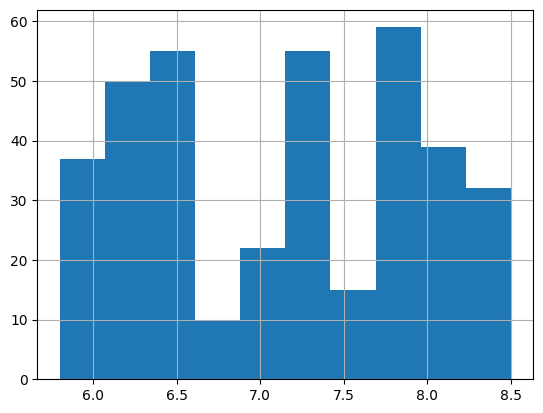

In [6]:
df.sleep_duration.hist()

<Axes: >

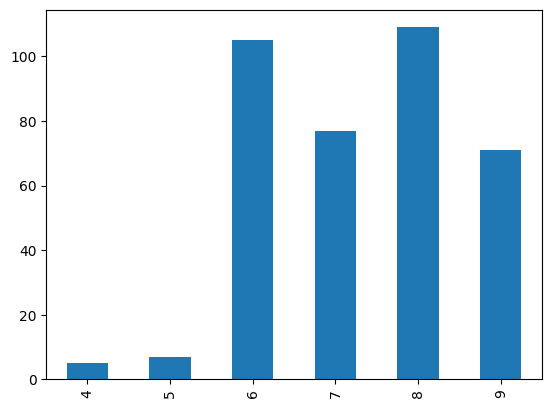

In [7]:
df.quality_of_sleep.value_counts().sort_index().plot.bar()

<Axes: >

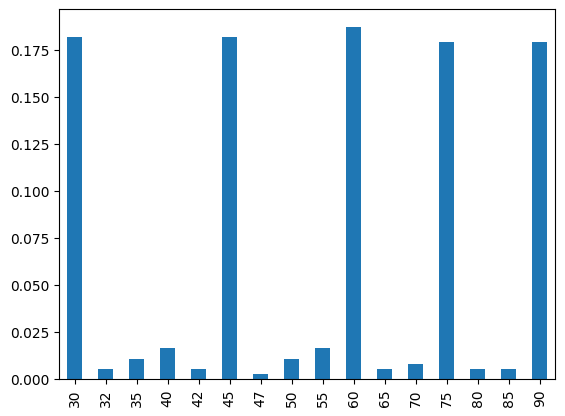

In [8]:
df.physical_activity_level.value_counts(normalize=True).sort_index().plot.bar() 

<Axes: >

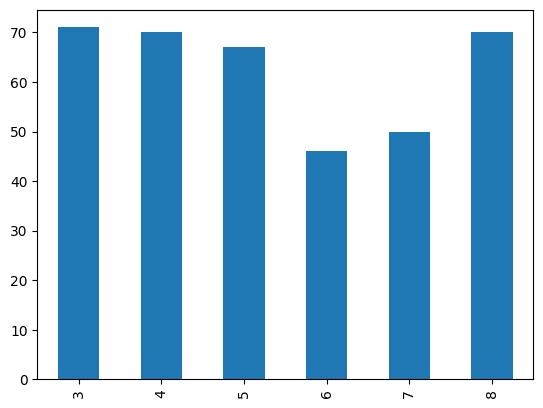

In [9]:
df.stress_level.value_counts().sort_index().plot.bar()

<Axes: >

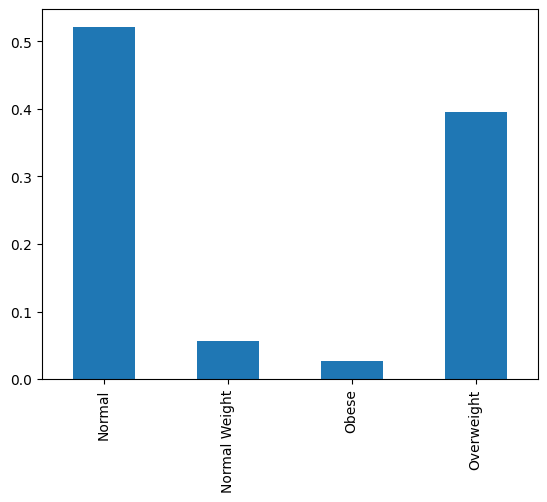

In [10]:
df.bmi_category.value_counts(normalize=True).sort_index().plot.bar()

In [11]:
df.daily_steps.value_counts()

8000     101
6000      68
5000      68
7000      66
10000     36
5500       4
3000       3
3500       3
4000       3
6800       3
4800       2
7300       2
7500       2
4200       2
3300       2
5600       2
5200       2
4100       2
3700       2
6200       1
Name: daily_steps, dtype: int64

<Axes: >

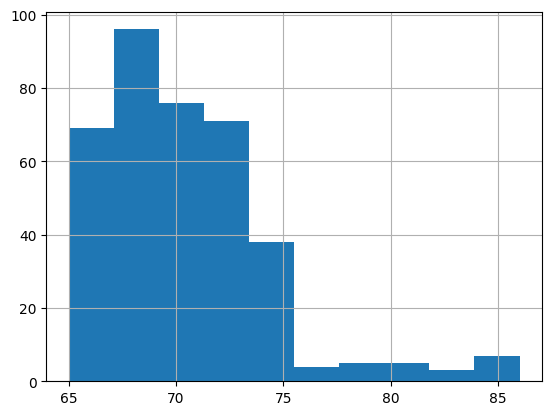

In [12]:
df.heart_rate.hist()

The first number (systolic) represents the pressure in your blood vessels when your heart beats. The second number (diastolic) represents the pressure in your vessels when your heart rests between beats. A normal blood pressure reading is typically around 120/80 mmHg

In [13]:
df.blood_pressure.value_counts()

130/85    99
140/95    65
125/80    65
120/80    45
115/75    32
135/90    27
140/90     4
125/82     4
132/87     3
128/85     3
126/83     2
115/78     2
139/91     2
142/92     2
119/77     2
135/88     2
129/84     2
128/84     2
131/86     2
117/76     2
130/86     2
118/75     2
121/79     1
122/80     1
118/76     1
Name: blood_pressure, dtype: int64

<Axes: >

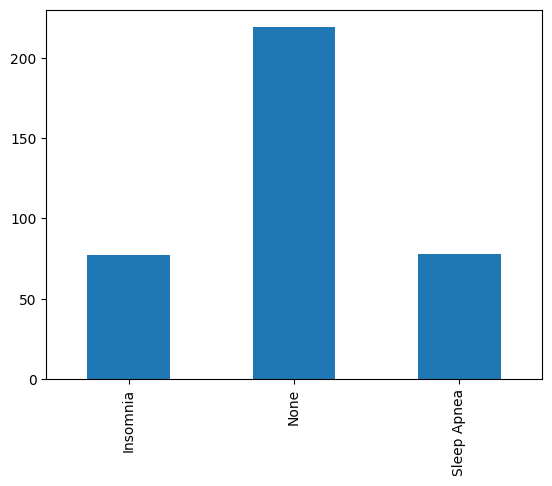

In [14]:
df.sleep_disorder.value_counts(normalize=False).sort_index().plot.bar()

# Building a Feature Selection Pipeline

In [15]:
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import chi2_contingency

In [16]:
def cleaning1(df) -> pd.DataFrame:
    """
    First cleaning pipeline
    """
    
    # Simplifying class
    cast_cat = {
        'None': 0,
        'Sleep Apnea': 1,
        'Insomnia' : 1
    }

    bmi_mapping = {
        'Overweight': 1,
        'Normal': 0,
        'Obese': 1,
        'Normal Weight': 0,
        }

    occupations_mapping = {
        'Software Engineer': 'technical',
        'Doctor': 'medical',
        'Sales Representative': 'humanities',
        'Teacher': 'humanities',
        'Nurse': 'medical',
        'Engineer': 'technical',
        'Accountant': 'technical',
        'Scientist': 'technical',
        'Lawyer': 'humanities',
        'Salesperson': 'humanities',
        'Manager': 'humanities'
    }

    # Mapping acording to the above dictionaries
    full_fr = (df
                    .join( pd.get_dummies(df['gender'], prefix='is', drop_first=True) )
                    #.join( pd.get_dummies(df['occupation'], prefix='raw_occ', drop_first=False) )
                    #.join( pd.get_dummies(df['bmi_category'], prefix='raw_bmi', drop_first=False) )
                    .assign( # ADDING EXTRA COLUMNS USSING THE MAPPINGS ABOVE
                        work_field = df['occupation'].map(occupations_mapping),
                        elevated_bmi = df['bmi_category'].map(bmi_mapping).astype('uint8'),
                        systolic_bp = df['blood_pressure'].str.split('/', expand=True)[0].astype('int64'),
                        diastolic_bp = df['blood_pressure'].str.split('/', expand=True)[1].astype('int64'),
                        ) 
                    .pipe( 
                            lambda _df: 
                                (_df
                                    .join( pd.get_dummies(_df['work_field'], prefix='wf', drop_first=False) ) # SETTING WORKFIELD DUMMIES
                                    .assign( sleep_issue = _df['sleep_disorder'].astype(str).map(cast_cat) ) # Fixing target variable
                                    )
                          )
                    .drop(columns=['gender', 'occupation', 'bmi_category', 'blood_pressure', 'sleep_disorder', 'work_field'])
                    )
    
    return full_fr

In [17]:
df1 = cleaning1(df)
df1.head()

,age,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,heart_rate,daily_steps,is_Male,elevated_bmi,systolic_bp,diastolic_bp,wf_humanities,wf_medical,wf_technical,sleep_issue
Person ID,,,,,,,,,,,,,,,
1,27,6.1,6,42,6,77,4200,1,1,126,83,0,0,1,0
2,28,6.2,6,60,8,75,10000,1,0,125,80,0,1,0,0
3,28,6.2,6,60,8,75,10000,1,0,125,80,0,1,0,0
4,28,5.9,4,30,8,85,3000,1,1,140,90,1,0,0,1
5,28,5.9,4,30,8,85,3000,1,1,140,90,1,0,0,1


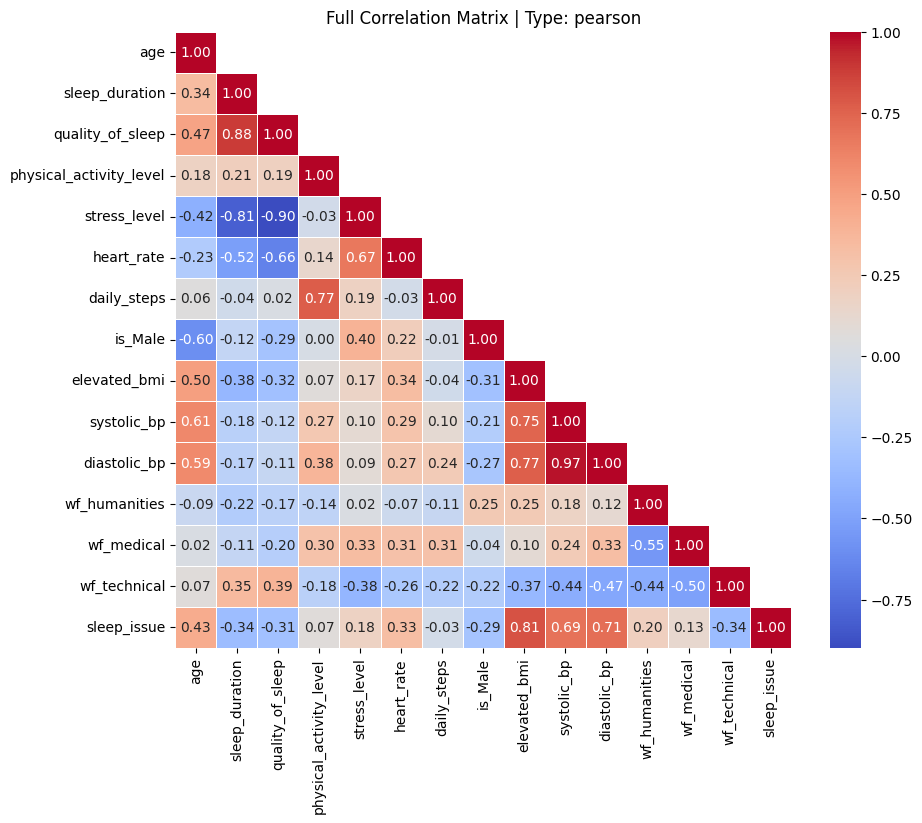

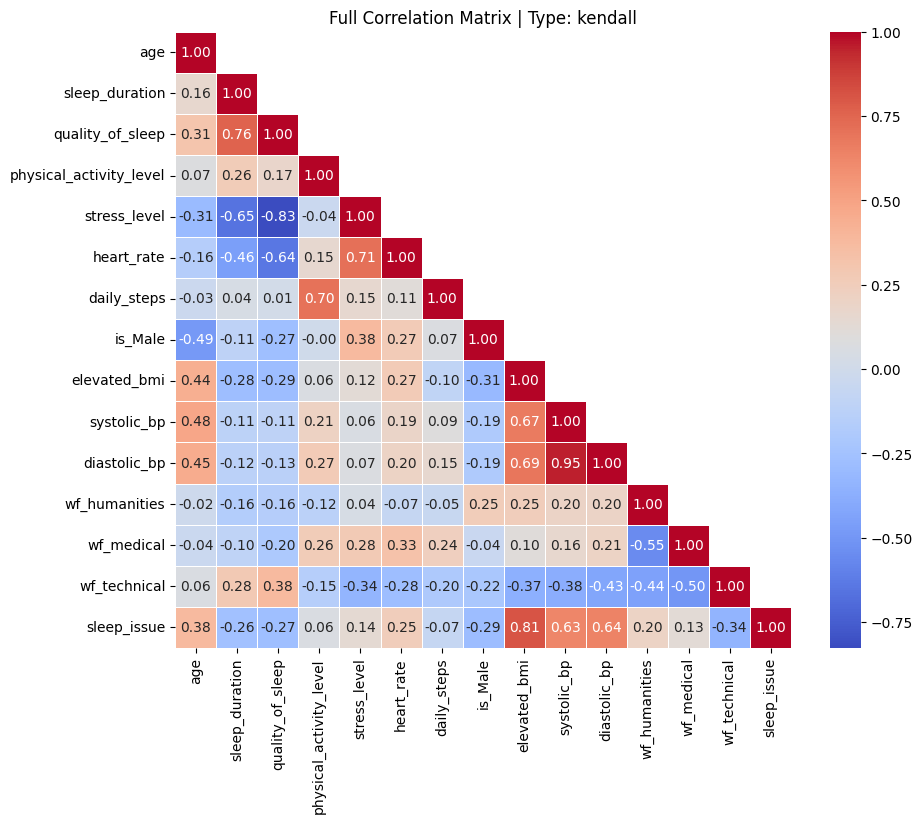

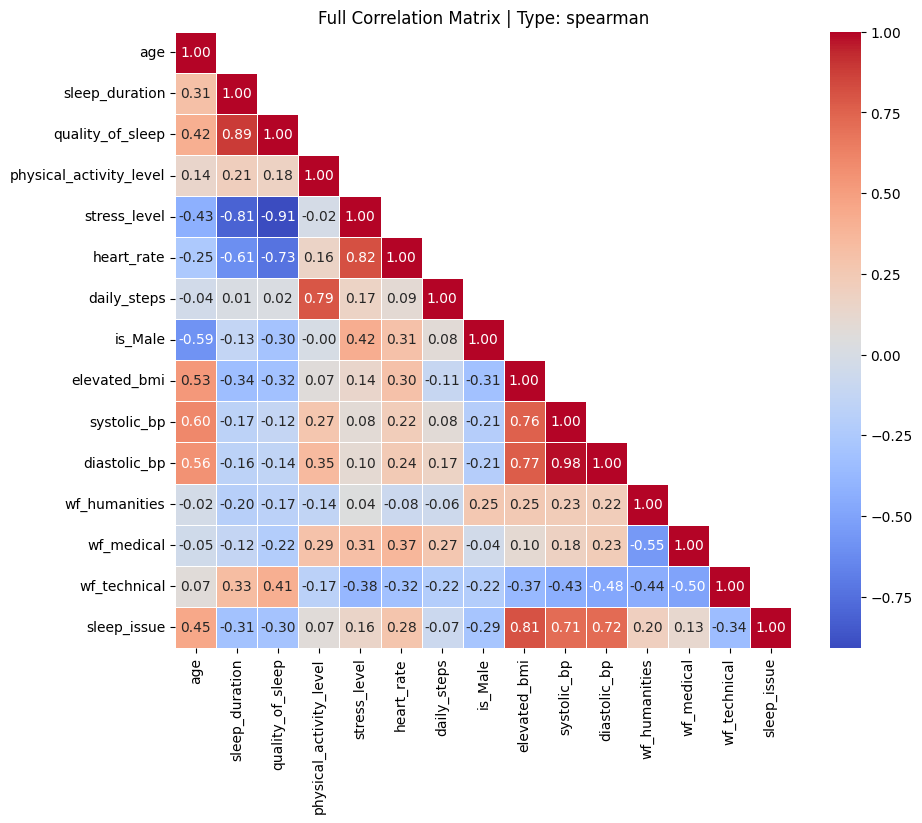

In [21]:
for CORR in ['pearson', 'kendall', 'spearman']:
    # Assuming you have the DataFrame 'df1' and you have calculated the correlation matrix
    correlation_matrix = df1.corr(method=CORR) # pearson | kendall |spearman 

    # Create the mask for the values at the top of the diagonal
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

    # Create the heatmap for the values at the top of the diagonal
    #plt.figure(figsize=(20, 17))
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix,
                cmap='coolwarm',
                annot=True,
                fmt=".2f",
                mask=mask,
                square=True,
                linewidths=0.5)
    plt.title(f"Full Correlation Matrix | Type: {CORR}")
    plt.show()

We find several columns correlated between eachother and information that could be redundant.

Such is the case of *stress_level* and *sleep_duration*.

Source lacks a description on the nature of the *stress_level* column, is also not possible to derive a conclusion from it because is a column that contains integer values that range from 3 to 8. Because of this ambiguity keeping it into the pipeline won't be useful when generalizing to another population.

Being *sleep_duration* an easier variable for an hypothetical user to use and to avoid colinearity effects with *sleep_duration*, let's add *stress_level* to the list of columns to leave out.

In [87]:
#df['stress_level'].hist()

In [22]:
columns_to_drop = ['stress_level']

On the other hand, some correlations require further consideration, for example, "Physical Activity" and "Daily steps" are highly correlated. Their histograms look like this:

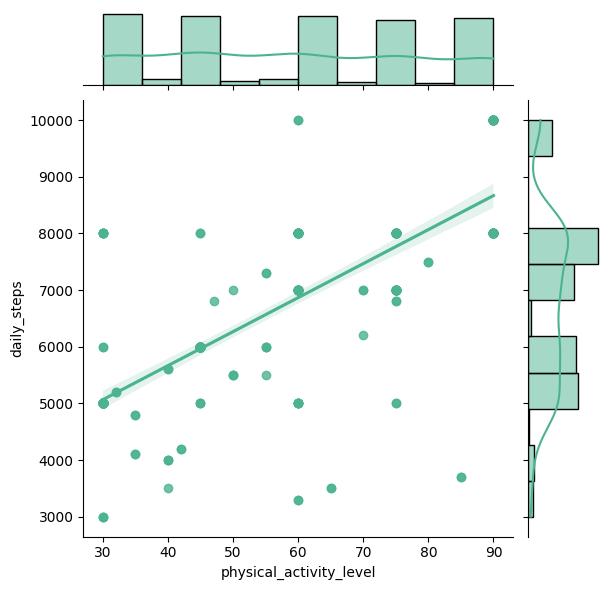

In [23]:
sns.jointplot(x=df1.physical_activity_level, y=df1.daily_steps, kind="reg", color="#4CB391")

We can see how *Physical Activity* histogram is a range that contains unexplained gaps and peaks, one can especulate that it can be more linked to subjective factors and generalizing this without context from the data source can make difficult to interpret and use in an algorithm for predictions.

But *Daily Steps* does not shows a better picture either, there isn't a high correlation with the target.

Let's keep *Daily Steps* conditionally, because in practicall terms is a value that the user can input and the algorithm use as a physical activity baseline, therefore, let's do another test called Phi Coefficient for *Daily steps* to assess the relevance with the target. 

In [24]:
#df1['daily_steps'].value_counts().sort_index().plot.bar()

In [25]:
# Create a cross-tabulation of the two columns
contingency_table = pd.crosstab(df1['daily_steps'], df1['sleep_issue'])

# Calculate the chi-square statistic and the p-value
chi2, p, _, _ = chi2_contingency(contingency_table)

# The Phi Coefficient is the square root of the chi2 statistic divided by the sum of the contingency table and the minimum dimension minus 1
phi_coefficient = np.sqrt(chi2 / (contingency_table.sum().sum() * (min(contingency_table.shape) - 1)))

print('Phi Coefficient:', phi_coefficient)

Phi Coefficient: 0.7383003115914518


The Phi Coef ranges between -1 and 1, but is showing a significance that can be of use in tree based models when adding this column. 

In the same way, let's compare *Sleep Duration* and *Quality of Sleep*:

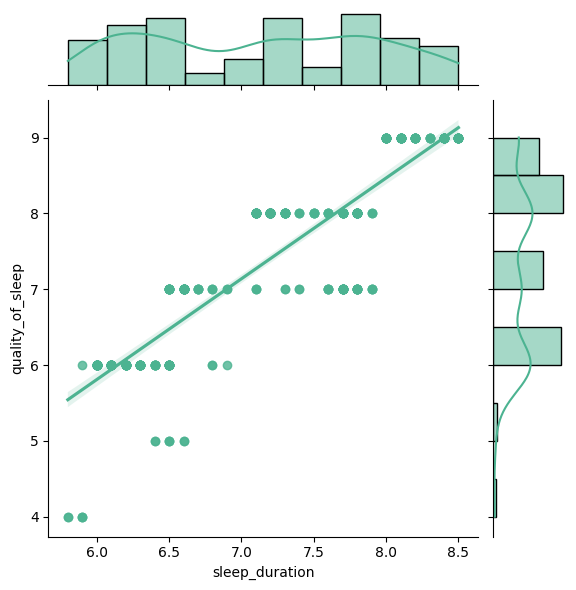

In [26]:
sns.jointplot(x=df1.sleep_duration, y=df1.quality_of_sleep, kind="reg", color="#4CB391")

Seems that the *quality of sleep* is a categorical rank that, although correlates well with *sleep duration*, its difficult to embed in a way that's easily understood to be of use in the prediction.

In [27]:
columns_to_drop += ['quality_of_sleep', 'physical_activity_level'] # 'wf_humanities', 'wf_medical']

Regarding the work-fields, by the correlation matrix the technical field (*wf_technicall*) is a better predictor than its two other counterparts. By keeping out any other fields, is possible reduce complexity for the user and in the training.

This way of categorizing helps in creating a distinction with the target column:

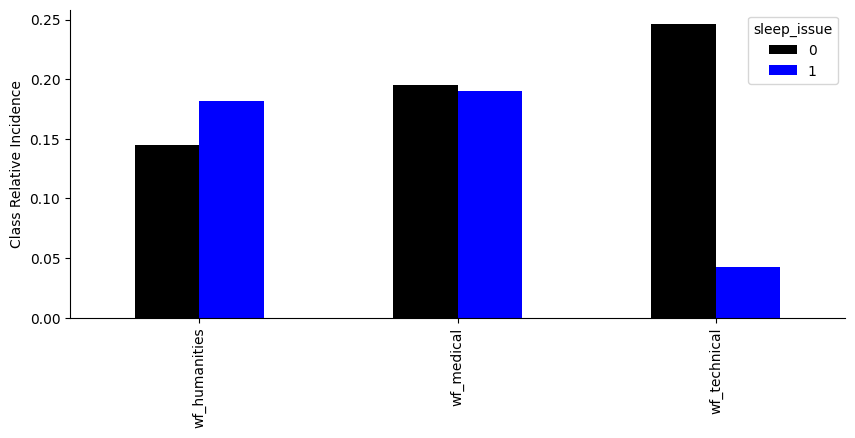

In [29]:
(df1.iloc[:, -4:]
    .groupby(by=['sleep_issue'])
    .sum()
    .T
    .div(len(df1))
    ).plot.bar(figsize=(10,4), color=['black','blue'])

plt.ylabel('Class Relative Incidence')
sns.despine(top=True, right=True)

In [30]:
columns_to_drop += ['wf_humanities', 'wf_medical']

We're left to assess the *systolic blood pressure* and *diastolic blood pressure*.

Let's recall. Systolic blood pressure refers to the amount of pressure experienced by the arteries while the heart is beating. Diastolic blood pressure refers to the amount of pressure in the arteries while the heart is resting in between heartbeats.

In all the correlation tests, we can se how these two columns correlate between each other and with the target. To avoid collinearity let's keep only one of these two, but the correlation coefficient changes slightly in all cases, so choosing one of the other based on the assessments we've conducted is indifferent. Someone, perhaps with medical knowledge or with another assessment test, can expand the selection criteria. For now, based on the correlation between the two and the fact that Systolic is always slightly more correlated with the target, this is the column we decide to keep.

In [31]:
columns_to_drop += ['diastolic_bp']

In [32]:
df1.drop(columns_to_drop, axis=1)

,age,sleep_duration,heart_rate,daily_steps,is_Male,elevated_bmi,systolic_bp,wf_technical,sleep_issue
Person ID,,,,,,,,,
1,27,6.1,77,4200,1,1,126,1,0
2,28,6.2,75,10000,1,0,125,0,0
3,28,6.2,75,10000,1,0,125,0,0
4,28,5.9,85,3000,1,1,140,0,1
5,28,5.9,85,3000,1,1,140,0,1
...,...,...,...,...,...,...,...,...,...
370,59,8.1,68,7000,0,1,140,0,1
371,59,8.0,68,7000,0,1,140,0,1
372,59,8.1,68,7000,0,1,140,0,1


With the table above we can start the process of training and assessing a machine learning algorithm for predicting *sleep_issue*.

A simpler design approach might involve ignoring the systolic column based on the context of its application. If it is a medical application, it can be included because it can be measured by a professional with the right equipment, but for the context of an user with a smartwatch this measurement cannot always be possible because some devices do not possess this feature and BMI is highly correlated with systolic column. 

We can safely drop it, but we'll see in the algorithm assessment notebook how keeping it does not help improve performance.